### RGB Ortho-Mosaics classification Using Supervised classification (Random Forest)

##### Prepared By : Ahmed Abdelwahab

The aim of my code is to apply random forest classification for RGB raster images collected using Airborne photogrammetry. The main goal is study the water bodies degradation.

The code also provides an accuracy assessment method to validate the training sample data before clustering all pixels in my images. 

The code was generally useful to have fair classification as the spatial resolution was 1 meter and sensitive to minor details unlike satellite images of 15-30 meter spatial resolution.

A useful tip in some noisy images to apply smoothing filters such as (Major filters or Nearest neighbors using either 4 or 8 pixels). furthermore, you can start test some morphology algorithms to clean the data before running the classification.

In [16]:
import rasterio
import rasterio.features
import rasterio.warp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.datasets import make_classification
import geopandas as gpd
from sklearn.model_selection import train_test_split
from shapely.geometry import mapping
from rasterio.mask import mask
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix

In [17]:
# reading the training sample file(shapefile format)

shapefile = "teshekpukCentral/Train/09749_014630916_1000_TS.shp"

train = gpd.read_file(shapefile)


In [18]:
train

,Classname,Classvalue,RED,GREEN,BLUE,Count,geometry
0,water,1,183,72,209,15082,"MULTIPOLYGON (((8.58472 0.36108, 8.37073 0.303..."
1,shallow water,14,149,130,152,3442,"MULTIPOLYGON (((15.38910 17.18048, 15.43188 16..."
2,Dry_Land,18,255,255,190,16508,"MULTIPOLYGON (((18.76849 26.92493, 18.43530 26..."
3,vegetation,25,230,152,0,8492,"MULTIPOLYGON (((10.79309 19.05328, 10.54547 18..."


C:\Users\Ahmed\Anaconda3\envs\SDA\lib\site-packages\rasterio\__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


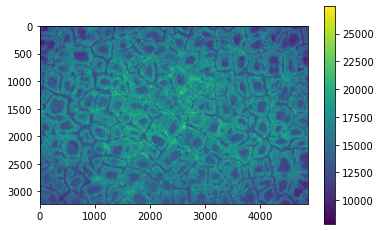

In [19]:
# Reading the raster image (teshekpukCentral RGB image)
im = rasterio.open('teshekpukCentral/09749_014630916_1000.tif')
im.transform

#Affine(X_size, 0.0, label.shape[1],
 #      0.0, -Y_size, label.shape[0])
#Display Band 1


plt.imshow(im.read(1))
plt.colorbar()


In [20]:
# Rename each class in case of RGB images
a = (im.read(1))
b = (im.read(2))
c = (im.read(3))

In [21]:
# merge all bands in one array 
rgb = np.c_[a.flatten(), b.flatten(), c.flatten()]
rgb.shape, rgb

((15720448, 3),
 array([[10483, 10163,  9112],
        [10483, 11284,  9951],
        [10635, 11400, 10791],
        ...,
        [13206, 14031, 11693],
        [13582, 12666, 10791],
        [13958, 12702, 10791]], dtype=uint16))

In [22]:
#Reshape of the RGB bands(Empty array) 
X16 = np.array([], dtype=np.float32).reshape(3, -1)

# labels for training(Empty Array)
y16 = np.array([], dtype=np.string_)

# create empty list to append all classes based on the training sample
out_image = []
for i in range(0,4):
    values = train.geometry.values[i]
    pol = [mapping(values)]
    classname = train['Classname'][i]
    out_im=mask(im, pol, crop=True, filled=True)[0]
    out_image=out_im[:, ~np.all(out_im == 0, axis=0)]    
    y16 = np.append(y16, [classname] * out_image.shape[1]) 
    X16 = np.hstack((X16, out_image))

In [23]:
# checking the shapes and data inside each array
y16, y16.shape, X16, X16.shape, out_image, out_image.shape

(array(['water', 'water', 'water', 'water', 'water', 'Dry_Land',
        'Dry_Land', 'vegetation'], dtype='<U32'),
 (8,),
 array([[11552.,  9491., 13924., 13957., 14500., 13583., 13585., 14062.],
        [11658., 10081., 14686., 13808., 13650., 12882., 13461., 13091.],
        [ 9555., 10443., 11288., 11235., 11030., 10842., 11046., 10791.]],
       dtype=float32),
 (3, 8),
 array([[14062],
        [13091],
        [10791]], dtype=uint16),
 (3, 1))

In [9]:
# RGB image bands - reshaped (data x 3)
X = np.moveaxis(X16, 0, -1)

# Training sample as string(T.data x 0)
y = np.moveaxis(y16, 0, -1)

In [10]:
X, X.shape, y, y.shape

(array([[11552., 11658.,  9555.],
        [ 9491., 10081., 10443.],
        [13924., 14686., 11288.],
        [13957., 13808., 11235.],
        [14500., 13650., 11030.],
        [13583., 12882., 10842.],
        [13585., 13461., 11046.],
        [14062., 13091., 10791.]], dtype=float32),
 (8, 3),
 array(['water', 'water', 'water', 'water', 'water', 'Dry_Land',
        'Dry_Land', 'vegetation'], dtype='<U32'),
 (8,))

In [11]:
# Define Training and test datasets before running the classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, stratify=None)

# Create the model with 100 Discion trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

# Fit on training data
model.fit(X_train, y_train.reshape(-1,1).ravel())

RandomForestClassifier(max_features='sqrt')

In [12]:
# predict the classes using 75% of the training sample data file (Apply RFC)
prd = model.predict(X_test)

In [13]:
# prediction vs main training sample accuracy report
print(classification_report(y_test, prd))

              precision    recall  f1-score   support

    Dry_Land       0.00      0.00      0.00         1
  vegetation       0.00      0.00      0.00         0
       water       1.00      1.00      1.00         1

    accuracy                           0.50         2
   macro avg       0.33      0.33      0.33         2
weighted avg       0.50      0.50      0.50         2



C:\Users\Ahmed\Anaconda3\envs\SDA\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed\Anaconda3\envs\SDA\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed\Anaconda3\envs\SDA\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed\Anaconda3\envs\SDA\li

In [14]:
# Estimate classification accuracy scores
from sklearn.metrics import accuracy_score
print('Accuracy Score : ', accuracy_score(y_test, prd))

Accuracy Score :  0.5


In [15]:
#Estimate Confusion metrics
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, prd)

array([[  9496,    265,      3, 414985],
       [   164,  14727,      0, 147148],
       [    27,      1,   7250, 456906],
       [     6,      1,     12, 921766]], dtype=int64)

In [16]:
y_test

array(['vegetation', 'vegetation', 'land', ..., 'water', 'vegetation',
       'water'], dtype='<U10')

In [17]:
prd

array(['water', 'water', 'water', ..., 'water', 'water', 'water'],
      dtype='<U10')

In [18]:
y_test.shape[0]

1972757

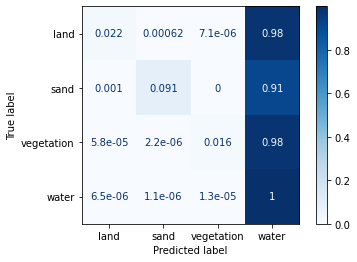

In [19]:
# Plot the accuracy assessment (Confusion matrix)
plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                    normalize=('true'))

In [20]:
# create input reshaped data for all pixels in raster images
X_prd = im.read()
X_prd = np.moveaxis(X_prd, 0, -1)
fx16 = []
for i in range(3):
    fx16.append(X_prd[:, :, i].flatten())
X_pred16 = np.array(fx16).T

In [21]:
# Checking the shape of the input RGB image for predicted RFC model
X_prd.shape

(3192, 3324, 3)

In [22]:
# Created predicted RFC model shape

y_pred_img = model.predict(X_pred16)

In [23]:
# Checking the shape of the predicted RFC model shape (string classes)
y_test.shape, prd.shape, y_pred_img.shape

((1972757,), (1972757,), (10610208,))

In [24]:
# Normalizing the labels and use numbers to replace the strings
le = preprocessing.LabelEncoder()
le.fit(y_pred_img)
label = le.transform(y_pred_img)

In [25]:
label, y_pred_img

(array([2, 2, 2, ..., 3, 3, 3]),
 array(['vegetation', 'vegetation', 'vegetation', ..., 'water', 'water',
        'water'], dtype='<U10'))

In [26]:
label.shape = im.read(1).shape

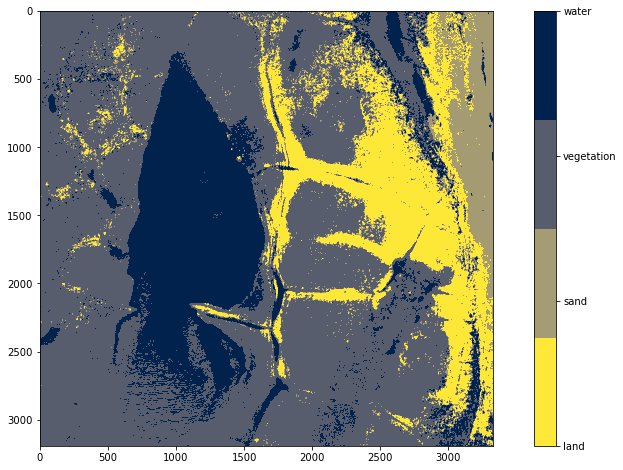

In [27]:
# Plot the classified data
plt.figure(figsize = (15, 8))
im = plt.imshow(label, cmap=plt.cm.get_cmap('cividis_r', len(np.unique(y_pred_img))))
cbar=plt.colorbar(im)
cbar.set_ticks(np.arange(len(np.unique(y_pred_img))))
cbar.set_ticklabels(np.unique(y_pred_img))

In [32]:
# extract the projection from the original image to use it for writing the raster image
import rasterio
src = rasterio.open('Ikpikpuk/06030_013601344_1000_BC_all.tif')
src.crs

In [33]:
# Write the raster image after classification
with rasterio.open('Ikpikpuk/06030_013601344_1000_BC_4classes_clustered6.tif', 'w',width=label.shape[1], height=label.shape[0],count=1, transform=src.transform,
                   dtype=(label).dtype) as dst:
    dst.write(label, indexes=1)